**Import Libraries**

In [1]:
from __future__ import print_function
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
tf.enable_eager_execution()

W0708 17:35:13.482460 139646456252032 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.


**Read CSV File and Randomize**

In [2]:
abalone_dataframe = pd.read_csv("abalone.csv")
abalone_dataframe.dropna()
abalone_dataframe = abalone_dataframe.reindex(np.random.permutation(abalone_dataframe.index))
#Male 0, Female 1, Infant 2
mapping = {"M" : 0, "F" : 1, "I" : 2}
abalone_dataframe = abalone_dataframe.replace({"sex" : mapping})
abalone_dataframe.head()

,sex,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,rings
2511,2,0.425,0.310,0.105,0.3650,0.1590,0.0825,0.105,6
558,1,0.660,0.530,0.170,1.3260,0.5190,0.2625,0.440,13
3659,0,0.545,0.410,0.140,0.7370,0.3490,0.1500,0.212,9
3856,2,0.335,0.255,0.085,0.1785,0.0710,0.0405,0.055,9
188,1,0.630,0.480,0.160,1.1990,0.5265,0.3350,0.315,11


**Create Training and Validation Data**

In [3]:
def preprocess_features(dataframe, selected_features):
    output_features = dataframe[selected_features]
    
    return output_features

In [4]:
#Single Panda Series
def preprocess_targets(dataframe, selected_target):
    output_targets = dataframe[selected_target]
    
    return output_targets

In [5]:
training_split = int(0.6 * len(abalone_dataframe))
validations_split = int(0.3 * len(abalone_dataframe))

selected_features = [
    "length",
    "diameter",
    "height",
    "whole-weight",
    #"shucked-weight",
    #"viscera-weight",
    #"shell-weight",
    #"rings"
]

selected_target = "sex"

#Feature Columns
feature_columns = {
    tf.feature_column.numeric_column("length"),
    tf.feature_column.numeric_column("diameter"),
    tf.feature_column.numeric_column("height"),
    tf.feature_column.numeric_column("whole-weight"),
    #tf.feature_column.numeric_column("shucked-weight"),
    #tf.feature_column.numeric_column("viscera-weight"),
    #tf.feature_column.numeric_column("shell-weight"),
    #tf.feature_column.numeric_column("rings")
}

In [6]:
#Panda Data
training_examples = preprocess_features(abalone_dataframe.iloc[0:training_split], selected_features)
training_targets = preprocess_targets(abalone_dataframe.iloc[0:training_split], selected_target)
validation_examples = preprocess_features(abalone_dataframe.iloc[training_split:training_split + validations_split], selected_features)
validation_targets = preprocess_targets(abalone_dataframe.iloc[training_split:training_split + validations_split], selected_target)
#Do not touch until end!
test_examples = preprocess_features(abalone_dataframe.iloc[training_split + validations_split:], selected_features)
test_targets = preprocess_targets(abalone_dataframe.iloc[training_split + validations_split:], selected_target)

**Training Functions**

In [7]:
#Return next batch (Of type of Tensorflow Dataset)
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), targets))
    
    if(shuffle):
        dataset = dataset.shuffle(1000)
    
    dataset = dataset.batch(batch_size).repeat(num_epochs)
    
    return dataset

In [8]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    n_classes,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 10
    steps_per_period = steps / periods
    
    #Initialize Linear Classifier
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
        feature_columns=feature_columns,
        n_classes=n_classes,
        optimizer=optimizer
    )
    
    #Training Functions
    training_input_fn = lambda: input_fn(
        training_examples,
        training_targets,
        batch_size=batch_size) 
    predict_training_input_fn = lambda: input_fn(
        training_examples, 
        training_targets, 
        num_epochs=1, 
        shuffle=False)
    
    #Validation Function
    predict_validation_input_fn = lambda: input_fn(
        validation_examples, 
        validation_targets, 
        num_epochs=1, 
        shuffle=False)
    
    #Train Model
    training_log_losses = []
    validation_log_losses = []
    
    print("Training Model")
    for period in range(0, periods):
        linear_classifier.train(
            input_fn=training_input_fn,
            #Manually break total steps by 10
            steps=steps_per_period
        )
        
        #Use Sklearn to calculate Log Loss
        training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        
        #Calculate Validation Log Loss
        validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        
        #Append Losses
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
        
        print("Period:", period, "Training Log Loss:", training_log_loss, "Validation Log Loss:", validation_log_loss)
    print("Training Finished")
    
    #Graph
    plt.ylabel("Log Loss")
    plt.xlabel("Periods")
    plt.title("Log Loss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="validation")
    plt.legend()
    
    return linear_classifier

In [9]:
def train_dnn_classifier_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    feature_columns,
    n_classes,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

    periods = 10
    steps_per_period = steps / periods
    
    #Initialize DNN Regressor
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    dnn_classifier = tf.estimator.DNNClassifier(
        feature_columns=feature_columns,
        n_classes=n_classes,
        hidden_units=hidden_units,
        optimizer=optimizer,
    )
    
    #Training Functions
    training_input_fn = lambda: input_fn(
        training_examples,
        training_targets,
        batch_size=batch_size) 
    predict_training_input_fn = lambda: input_fn(
        training_examples, 
        training_targets, 
        num_epochs=1, 
        shuffle=False)
    
    #Validation Function
    predict_validation_input_fn = lambda: input_fn(
        validation_examples, 
        validation_targets, 
        num_epochs=1, 
        shuffle=False)
    
    #Train Model
    training_log_losses = []
    validation_log_losses = []
    
    print("Training Model")
    for period in range(0, periods):
        dnn_classifier.train(
            input_fn=training_input_fn,
            #Manually break total steps by 10
            steps=steps_per_period
        )
        
        #Use Sklearn to calculate Log Loss
        training_probabilities = dnn_classifier.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        
        #Calculate Validation Log Loss
        validation_probabilities = dnn_classifier.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        
        #Append Losses
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
        
        print("Period:", period, "Training Log Loss:", training_log_loss, "Validation Log Loss:", validation_log_loss)
    print("Training Finished")
    
    #Graph
    plt.ylabel("Log Loss")
    plt.xlabel("Periods")
    plt.title("Log Loss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="validation")
    plt.legend()
    
    return dnn_classifier

**Training**

W0708 17:35:19.064284 139646456252032 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0708 17:35:19.065380 139646456252032 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpibidm09f
W0708 17:35:19.073912 139646456252032 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Training Model


W0708 17:35:19.466544 139646456252032 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:308: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0708 17:35:19.709558 139646456252032 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/ops/clip_ops.py:286: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0708 17:35:21.827399 139646456252032 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for f

Period: 0 Training Log Loss: 1.0527333870042541 Validation Log Loss: 1.0583133091473713


W0708 17:35:25.485152 139646456252032 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1066: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.


Period: 1 Training Log Loss: 1.0264991774429633 Validation Log Loss: 1.0342154817779066


W0708 17:35:31.380033 139646456252032 basic_session_run_hooks.py:724] It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 3840 vs previous value: 3840. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.
W0708 17:35:31.823383 139646456252032 basic_session_run_hooks.py:724] It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 4154 vs previous value: 4154. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.


Period: 2 Training Log Loss: 1.00520447110616 Validation Log Loss: 1.0146516470174645


W0708 17:35:35.662608 139646456252032 basic_session_run_hooks.py:724] It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 4791 vs previous value: 4791. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.


Period: 3 Training Log Loss: 0.9875499767393278 Validation Log Loss: 0.998486208325848


W0708 17:35:41.528778 139646456252032 basic_session_run_hooks.py:724] It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 7377 vs previous value: 7377. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.
W0708 17:35:41.620564 139646456252032 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Period: 4 Training Log Loss: 0.9726115903755426 Validation Log Loss: 0.9850960130322388


W0708 17:35:46.011996 139646456252032 basic_session_run_hooks.py:724] It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 7996 vs previous value: 7996. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.


Period: 5 Training Log Loss: 0.9600966862935784 Validation Log Loss: 0.9739556253099099
Period: 6 Training Log Loss: 0.9495708051911375 Validation Log Loss: 0.9647581631054616
Period: 7 Training Log Loss: 0.940548494993356 Validation Log Loss: 0.9571583979575042
Period: 8 Training Log Loss: 0.9329354292924938 Validation Log Loss: 0.9507169625993167
Period: 9 Training Log Loss: 0.926364239557971 Validation Log Loss: 0.9454277799972418
Training Finished


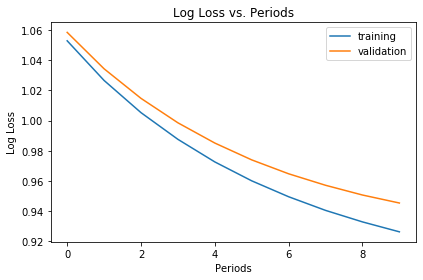

In [10]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.0001,
    steps=15000,
    batch_size=20,
    feature_columns=feature_columns,
    n_classes=3,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

W0708 17:36:10.512669 139646456252032 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpr3t3jb1k
W0708 17:36:10.575408 139646456252032 deprecation.py:506] From /usr/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Training Model
Period: 0 Training Log Loss: 1.0955314433584191 Validation Log Loss: 1.098375525364187
Period: 1 Training Log Loss: 1.0955476566304803 Validation Log Loss: 1.0982285308914002
Period: 2 Training Log Loss: 1.0955485202794253 Validation Log Loss: 1.09823453012506
Period: 3 Training Log Loss: 1.0955363802926976 Validation Log Loss: 1.0983746357660529
Period: 4 Training Log Loss: 1.0955436971315078 Validation Log Loss: 1.0982469031074384
Period: 5 Training Log Loss: 1.0955362142987568 Validation Log Loss: 1.0983838573609555
Period: 6 Training Log Loss: 1.0955532884607293 Validation Log Loss: 1.0983776050572955
Period: 7 Training Log Loss: 1.0955509708009523 Validation Log Loss: 1.0984884669851134
Period: 8 Training Log Loss: 1.0955654785619768 Validation Log Loss: 1.0981890176261604
Period: 9 Training Log Loss: 1.0955834269333342 Validation Log Loss: 1.098072832998807
Training Finished


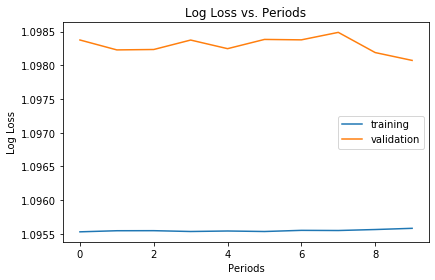

In [11]:
dnn_classifier = train_dnn_classifier_model(
    learning_rate=0.001,
    steps=15000,
    batch_size=20,
    hidden_units=[5, 4, 3],
    feature_columns=feature_columns,
    n_classes=3,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

**Test Data**

In [12]:
def test_classifier_model(model, test_examples, test_targets):
    predict_test_input_fn = lambda: input_fn(
        test_examples, 
        test_targets, 
        num_epochs=1, 
        shuffle=False)
    
    test_probabilities = model.predict(input_fn=predict_test_input_fn)
    test_probabilities = np.array([item['probabilities'] for item in test_probabilities])

    for probabilities, label in zip(test_probabilities, test_targets): 
        if(max(probabilities) == probabilities[label]):
            print("Probability:", probabilities, "Label:", label)
        else:
            print("Probability:", probabilities, "Label:", label, "Wrong")
    
    evaluation = model.evaluate(input_fn=predict_test_input_fn)
    print(evaluation)
    
    return test_probabilities

In [13]:
#Linear Classifier
test_probabilities_linear_classifier = test_classifier_model(linear_classifier, test_examples, test_targets)

Probability: [0.2638252  0.21993162 0.5162431 ] Label: 2
Probability: [0.20673718 0.17136282 0.62189996] Label: 2
Probability: [0.41634566 0.35365984 0.22999458] Label: 2 Wrong
Probability: [0.30149147 0.25238636 0.4461222 ] Label: 2
Probability: [0.36124238 0.3045594  0.3341982 ] Label: 0
Probability: [0.2156662  0.17895557 0.60537815] Label: 2
Probability: [0.30091795 0.25190905 0.447173  ] Label: 1 Wrong
Probability: [0.51189613 0.4481824  0.03992148] Label: 0
Probability: [0.2814989 0.2352094 0.4832917] Label: 1 Wrong
Probability: [0.31636852 0.2653574  0.41827407] Label: 0 Wrong
Probability: [0.51174337 0.44796413 0.04029246] Label: 0
Probability: [0.33259073 0.2794288  0.38798043] Label: 0 Wrong
Probability: [0.45501685 0.389242   0.15574118] Label: 1 Wrong
Probability: [0.35111117 0.29558736 0.35330147] Label: 0 Wrong
Probability: [0.3122626  0.26173273 0.42600468] Label: 1 Wrong
Probability: [0.44015297 0.3755331  0.18431392] Label: 2 Wrong
Probability: [0.21404864 0.1775521  0

{'accuracy': 0.5334928, 'average_loss': 0.93127906, 'loss': 0.93127906, 'global_step': 15000}


In [14]:
#DNN Classifier
test_probabilities_dnn_classifier = test_classifier_model(dnn_classifier, test_examples, test_targets)

Probability: [0.3654023  0.31272554 0.32187214] Label: 2 Wrong
Probability: [0.3654023  0.31272554 0.32187214] Label: 2 Wrong
Probability: [0.3654023  0.31272554 0.32187214] Label: 2 Wrong
Probability: [0.3654023  0.31272554 0.32187214] Label: 2 Wrong
Probability: [0.3654023  0.31272554 0.32187214] Label: 0
Probability: [0.3654023  0.31272554 0.32187214] Label: 2 Wrong
Probability: [0.3654023  0.31272554 0.32187214] Label: 1 Wrong
Probability: [0.3654023  0.31272554 0.32187214] Label: 0
Probability: [0.3654023  0.31272554 0.32187214] Label: 1 Wrong
Probability: [0.3654023  0.31272554 0.32187214] Label: 0
Probability: [0.3654023  0.31272554 0.32187214] Label: 0
Probability: [0.3654023  0.31272554 0.32187214] Label: 0
Probability: [0.3654023  0.31272554 0.32187214] Label: 1 Wrong
Probability: [0.3654023  0.31272554 0.32187214] Label: 0
Probability: [0.3654023  0.31272554 0.32187214] Label: 1 Wrong
Probability: [0.3654023  0.31272554 0.32187214] Label: 2 Wrong
Probability: [0.3654023  0.3

{'accuracy': 0.37799042, 'average_loss': 1.0944803, 'loss': 1.0944803, 'global_step': 15000}


**Additional Info**

In [15]:
#Linear Classifier Weights
for v in linear_classifier.get_variable_names():
    print(v, linear_classifier.get_variable_value(v))

global_step 15000
linear/linear_model/bias_weights [-0.36427435 -0.55326504  0.9175389 ]
linear/linear_model/diameter/weights [[ 0.03310388  0.03059333 -0.06369696]]
linear/linear_model/height/weights [[ 0.01917045  0.03207209 -0.05124255]]
linear/linear_model/length/weights [[ 0.01711713  0.01185497 -0.02897207]]
linear/linear_model/whole-weight/weights [[ 0.6484295  0.6794187 -1.3278475]]


In [16]:
#DNN Classifier Weights
for v in dnn_classifier.get_variable_names():
    print(v, "\n", dnn_classifier.get_variable_value(v))

dnn/hiddenlayer_0/bias 
 [0. 0. 0. 0. 0.]
dnn/hiddenlayer_0/kernel 
 [[ 0.7097728  -0.0618729  -0.08509386  0.7137395   0.18627131]
 [ 0.70141745  0.05438322  0.31876683  0.48590314  0.7818954 ]
 [-0.5962707   0.41421604  0.44987357 -0.52498835  0.35252988]
 [-0.5216064   0.6338352   0.7826561   0.65573204  0.71445143]]
dnn/hiddenlayer_1/bias 
 [0. 0. 0. 0.]
dnn/hiddenlayer_1/kernel 
 [[ 0.4358431   0.33241796 -0.38178864 -0.37363303]
 [ 0.27835965  0.28887308  0.29125476 -0.63849497]
 [-0.78618973  0.12776566  0.3125645   0.5418292 ]
 [-0.45248407 -0.81028515 -0.8137919   0.18014187]
 [-0.5472272  -0.7826437  -0.6874985  -0.5242881 ]]
dnn/hiddenlayer_2/bias 
 [0. 0. 0.]
dnn/hiddenlayer_2/kernel 
 [[ 0.59462965  0.7658385  -0.33671802]
 [-0.1793738  -0.04830295  0.5041379 ]
 [-0.32100475 -0.14016902  0.6273323 ]
 [ 0.31957507  0.5035      0.11883724]]
dnn/logits/bias 
 [ 0.09417247 -0.06150053 -0.03267211]
dnn/logits/kernel 
 [[ 0.205127    0.16545987 -0.2844212 ]
 [-0.39368415 -0.2955